### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [6]:
%matplotlib inline

In [7]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [8]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


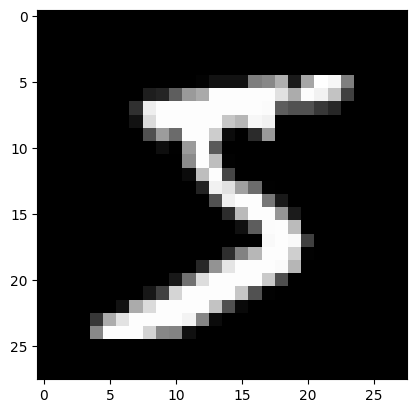

In [9]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [10]:
import torch

# 将数据都转换为tensor形式
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [11]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [23]:
bs = 64 # 每个batch的样本个数
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
# bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(16.1458, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [39]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x      

In [40]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


可以打印我们定义好名字里的权重和偏置项

In [41]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 2.9197e-02, -2.0047e-02, -3.3006e-02,  ...,  1.4537e-02,
         -3.2849e-02, -9.5268e-03],
        [-2.5251e-02, -1.5324e-02,  1.0877e-02,  ..., -1.7610e-03,
         -2.5346e-02, -9.0852e-03],
        [ 5.6030e-03,  1.4431e-02, -2.6231e-02,  ...,  2.7687e-03,
          3.0335e-02, -3.5705e-02],
        ...,
        [ 2.8270e-02,  2.2885e-02,  6.7088e-04,  ...,  2.9183e-03,
          1.7280e-02, -6.2007e-03],
        [-3.0118e-02,  2.0998e-02,  8.3384e-04,  ..., -2.7105e-02,
          1.3411e-05, -1.7489e-02],
        [-3.0761e-02, -2.8235e-02, -3.3469e-02,  ...,  3.1125e-02,
          1.7620e-02, -2.1721e-02]], requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-1.2239e-02,  1.9330e-02,  3.1405e-02, -1.6772e-02,  2.4372e-02,
        -9.2168e-03,  2.6496e-03,  4.3175e-03,  2.4881e-02,  4.6234e-03,
        -1.8851e-02,  2.9611e-02, -2.3438e-02, -2.6120e-02,  2.2516e-02,
        -8.2630e-03, -3.3510e-02, 

### 使用TensorDataset和DataLoader来简化

In [42]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [43]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [44]:
import numpy as np

"""
steps：迭代轮次
model：定义的模型
loss_func：选用的损失函数
opt：优化器
train_dl，valid_dl：数据打包器
"""
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()   # 模型训练模式，更新w，b参数
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()   # 模型验证模式，不更新参数
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [59]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)

In [60]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()  # 执行参数更新
        opt.zero_grad()   # 参数更新会累加，每次更新需要清零

    return loss.item(), len(xb)

### 三行搞定！

In [62]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(20, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.18480994064509867
当前step:1 验证集损失：0.135412650847435
当前step:2 验证集损失：0.1229504235394299
当前step:3 验证集损失：0.11045839943625033
当前step:4 验证集损失：0.1022945135096088
当前step:5 验证集损失：0.10072641502907499
当前step:6 验证集损失：0.09387844404689967
当前step:7 验证集损失：0.09450792992897332
当前step:8 验证集损失：0.10118313824608922
当前step:9 验证集损失：0.08971101570837199
当前step:10 验证集损失：0.09323752955175005
当前step:11 验证集损失：0.09344028095975518
当前step:12 验证集损失：0.08932371943593025
当前step:13 验证集损失：0.09403074770974927
当前step:14 验证集损失：0.09083311373237521
当前step:15 验证集损失：0.08558347255587578
当前step:16 验证集损失：0.08581872492502443
当前step:17 验证集损失：0.08642581661334262
当前step:18 验证集损失：0.08600561380148865
当前step:19 验证集损失：0.08686897720980924


## 计算当前模型的准确率

In [63]:
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1)   # 最大的值和索引
    total += yb.size(0)
    correct += (predicted == yb).sum().item()   # item()将tensor数值转换为非tensor数值
    
print('Accuracy of the network on the 10000 test images:%d %%' % (100 * correct /total))

Accuracy of the network on the 10000 test images:97 %


In [54]:
for xb, yb in valid_dl:
    outputs = model(xb)
    print(outputs)   # outputs为128个样本，每个类别上的结果
    print(outputs.shape)
    break

tensor([[-1.6236,  1.7055,  3.3517,  ..., -3.1295,  2.3263, -3.8307],
        [-2.4190, -0.4384,  0.6736,  ..., -2.6797,  5.1884, -0.5277],
        [ 1.1474, -3.0126,  1.7461,  ..., -3.2554, -1.0335, -0.8202],
        ...,
        [-0.0230, -3.1434,  1.4550,  ..., -4.5834, -0.7045, -0.6090],
        [ 0.6281, -2.3088, -1.9627,  ...,  3.2865, -0.4041,  2.2118],
        [11.1206, -9.4713,  1.4619,  ..., -3.4844,  1.9957, -2.9859]],
       grad_fn=<AddmmBackward0>)
torch.Size([128, 10])


In [56]:
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1)  # max中1为找到outputs.data上1维度上最大值，torch.max输出的是最大值与最大值的位置
    print(_)
    print(predicted)
    break

tensor([ 5.2560,  5.1884,  5.3310,  5.1276,  7.3357,  2.8372,  4.8775,  4.2726,
         4.5044,  3.0660,  4.5199,  7.1888,  7.5137,  5.1188,  6.1942,  6.1329,
         5.3491,  4.3617,  8.2480,  5.4524,  5.2870,  5.1842,  5.2983,  5.1747,
         5.2247,  2.8463,  5.3378,  5.7977,  8.2276,  5.0422,  6.4467,  4.2861,
         6.5015,  4.8221,  7.5252,  3.6740, 12.2584,  3.2710,  5.8779,  6.8502,
         6.3970,  4.1630,  7.0039,  5.3202,  3.4703,  6.0395,  4.0888,  5.0103,
         4.1068,  2.0804,  6.2757,  5.0340,  5.1560,  4.3808,  3.9319,  5.8758,
         4.4385,  7.1871,  6.5447,  5.0617,  4.6731, 11.0784,  6.7623,  7.3793,
         6.3992,  6.3667,  8.9351,  3.6713,  4.8611,  5.4825,  8.6752,  2.8028,
         9.9752,  7.1613,  2.2207,  4.8144,  5.0097,  6.6234,  4.2476,  4.9576,
         4.2674,  8.5666,  3.8869,  7.0623,  3.9467,  5.6264,  6.5817,  4.3088,
         3.4209,  6.5322,  2.1119,  3.1402,  8.2541,  9.5157,  4.0267,  9.7801,
         8.8906,  5.8061,  8.2072,  5.55

## zip的用法

In [19]:
a = [1, 2, 3]
b = [4, 5, 6]
zipped = zip(a, b)
print(list(zipped))
a2, b2 = zip(*zip(a, b))
print(a2)
print(b2)

[(1, 4), (2, 5), (3, 6)]
(1, 2, 3)
(4, 5, 6)


In [21]:
print(*zip(a, b))

(1, 4) (2, 5) (3, 6)


In [22]:
print(zip(*zip(a, b)))